In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_absolute_error,r2_score,mean_squared_error
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
df = pd.read_csv('After_feat.csv')

In [19]:
# Sort by Date just in case
df = df.sort_values("Date")

# Drop rows with missing engineered features (like lag)
df_model = df.dropna(subset=["Sales_lag1", "Sales_roll_mean_7"])

# Select features to train on
features = [
    "Store", "DayOfWeek", "Promo", "SchoolHoliday", "StoreType", "Assortment",
    "Month", "Year", "Day", "Weekofyear", "Quarter", "IsPromoMonth",
    "CompOpenMonthsAgo", "Promo2OpenWeeksAgo", "Sales_lag1", "Sales_lag7", "Sales_roll_mean_7"
]

target = "Sales"

# Split into train and test using date
train_df = df_model[df_model["Date"] < "2015-06-01"]
test_df  = df_model[df_model["Date"] >= "2015-06-01"]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("Linear Regression:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lr_preds)))
print("R² Score:", r2_score(y_test, lr_preds))

Linear Regression:
RMSE: 1530.204577057317
R² Score: 0.7580876162198209


In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("R² Score:", r2_score(y_test, rf_preds))

Random Forest:
RMSE: 1028.8669535560032
R² Score: 0.8906352047780712


In [29]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("R² Score:", r2_score(y_test, xgb_preds))

XGBoost:
RMSE: 1032.6752877841127
R² Score: 0.8898240923881531


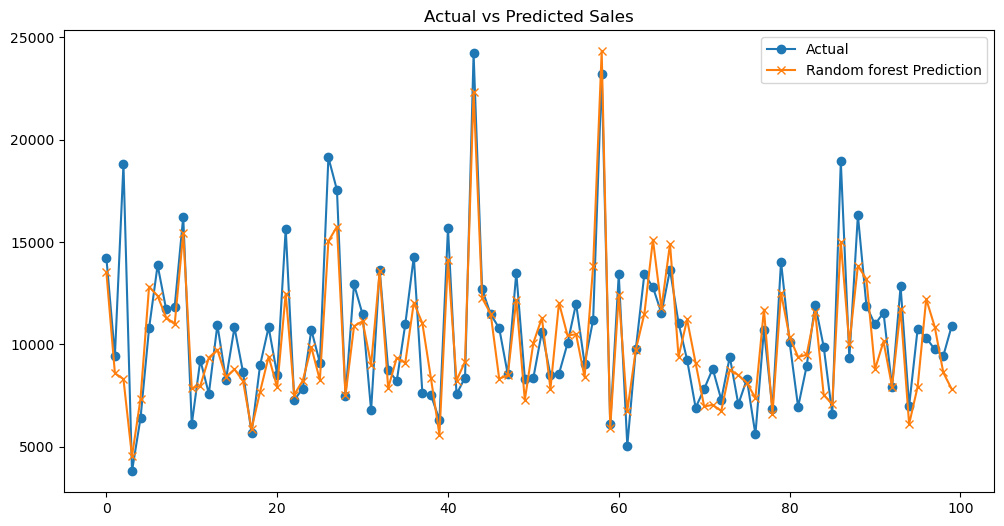

In [33]:
# Plot actual vs predicted sales for XGBoost
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual", marker='o')
plt.plot(rf_preds[:100], label="Random forest Prediction", marker='x')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

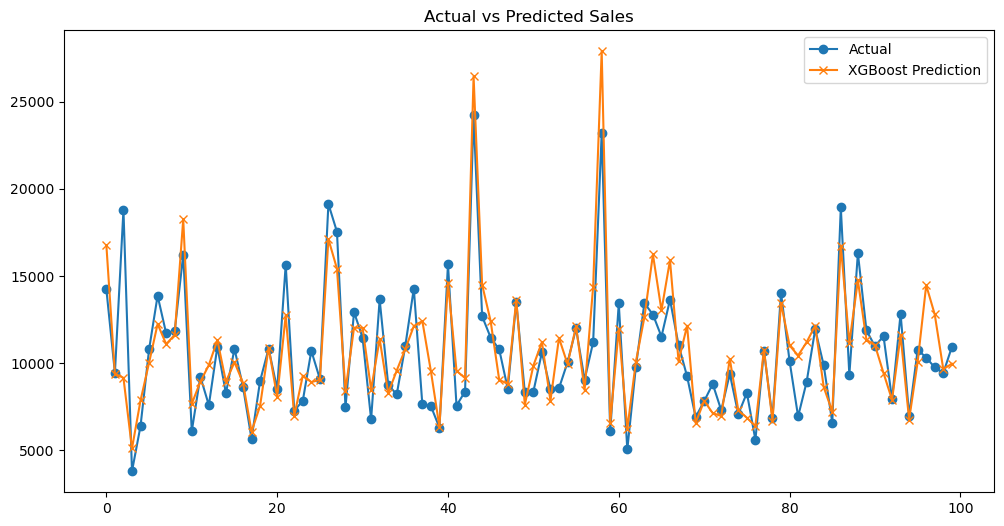

In [35]:
# Plot actual vs predicted sales for XGBoost
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual", marker='o')
plt.plot(xgb_preds[:100], label="XGBoost Prediction", marker='x')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

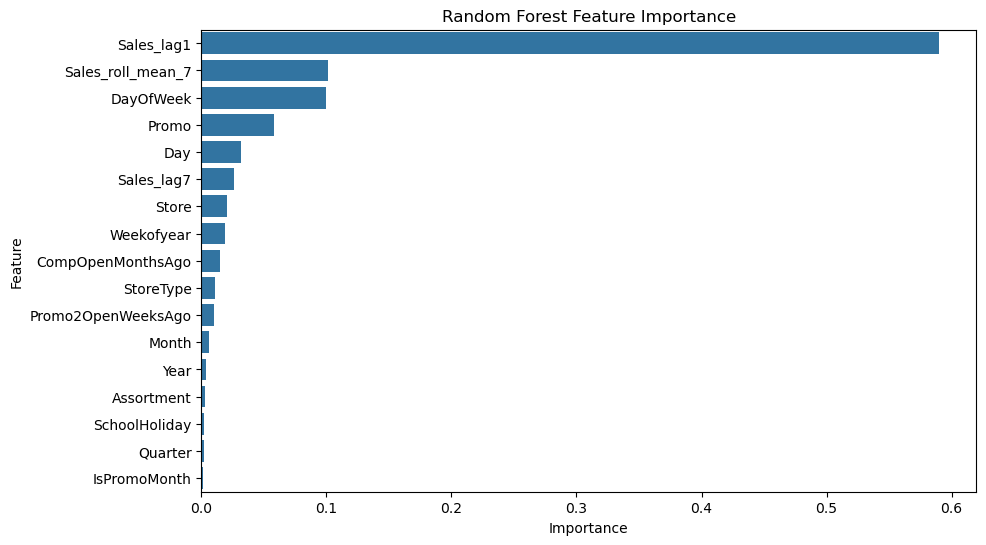

In [39]:
# Create DataFrame with features and importance
rf_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_importance)
plt.title("Random Forest Feature Importance")
plt.show()

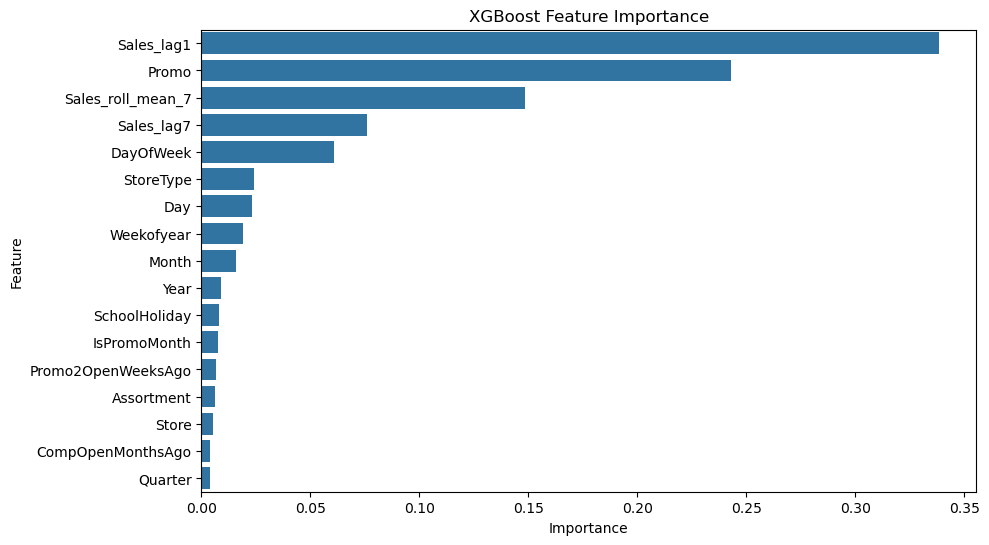

In [41]:
# Get importance from trained model
xgb_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=xgb_importance)
plt.title("XGBoost Feature Importance")
plt.show()

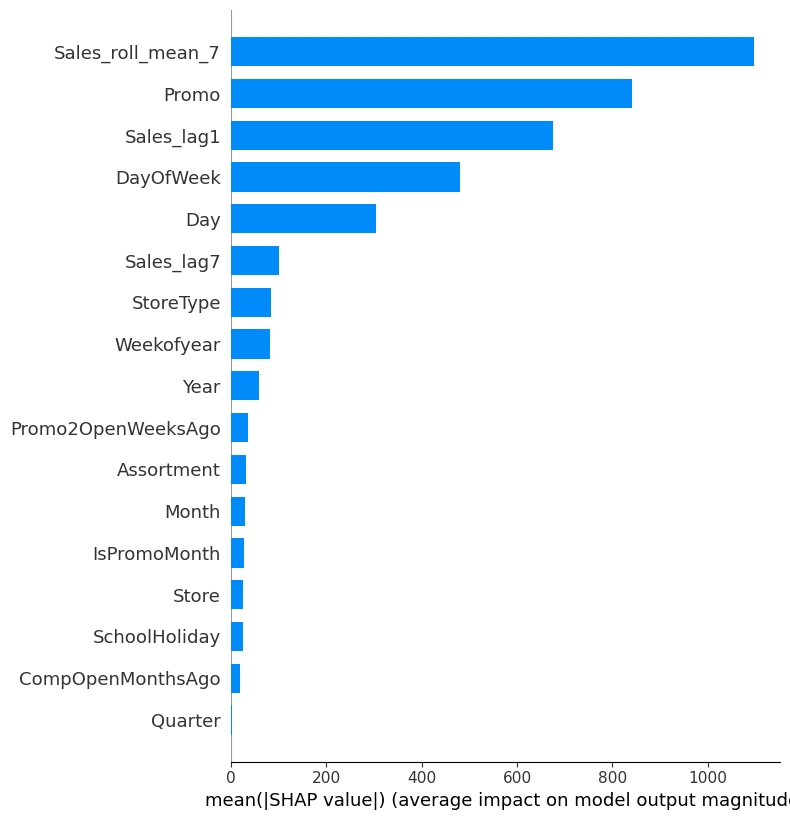

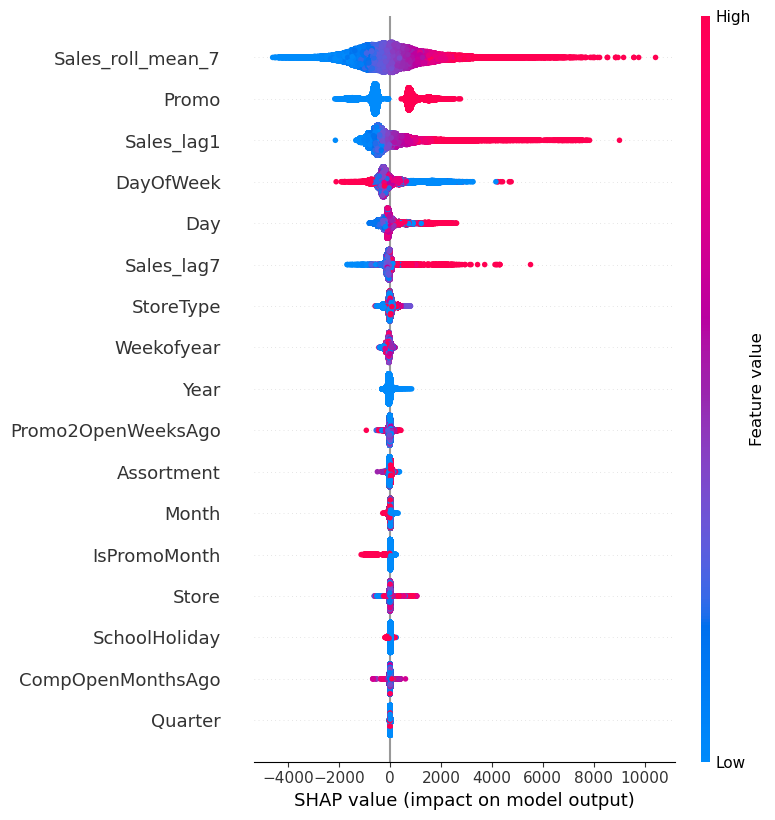

In [43]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


In [45]:
import joblib

joblib.dump(xgb_model, "model/xgb_model.pkl")


['model/xgb_model.pkl']

In [47]:
df_model.to_csv("data/processed_df.csv", index=False)


In [ ]:
!streamlit run app.py